In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kala/Sale.CSV', encoding='unicode_escape')

<ipython-input-2-03d685bd6ac4>:1: DtypeWarning: Columns (0,30,31,32,36,37,38,39,40,41,42,43,44,45,46,55,59,60,64) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kala/Sale.CSV', encoding='unicode_escape')


In [ ]:
reqd_sales = data[['Invoice date','Net Unit Price','Invoice Qty','Product Group','Sales Zone']]

In [ ]:
reqd_sales['Invoice date'] = pd.to_datetime(reqd_sales['Invoice date'],format = '%d.%m.%Y')
reqd_sales['Date'] = reqd_sales['Invoice date'].dt.strftime('%Y/%m/%d')

<ipython-input-4-55d5cf5b12a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reqd_sales['Invoice date'] = pd.to_datetime(reqd_sales['Invoice date'],format = '%d.%m.%Y')


In [ ]:
reqd_sales['Sales'] = reqd_sales['Invoice Qty']*reqd_sales['Net Unit Price']

<ipython-input-5-e699550b0c75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reqd_sales['Sales'] = reqd_sales['Invoice Qty']*reqd_sales['Net Unit Price']


In [ ]:
reqd_sales.sample(10)

<ipython-input-6-1f7e30e3d2de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reqd_sales['Date'] = reqd_sales['Invoice date'].dt.strftime('%Y/%m/%d')


,Invoice date,Net Unit Price,Invoice Qty,Product Group,Sales Zone,Sales,Date
2802,2023-04-13,7950.15,3,10BD,South Zone,23850.45,2023/04/13
31182,2023-02-09,1950.00,40,10DA,North Zone,78000.00,2023/02/09
4429,2023-05-19,175.00,200,10TA,West Zone,35000.00,2023/05/19
38,2023-05-03,19403.37,3,10BD,West Zone,58210.11,2023/05/03
25994,2023-06-23,361.80,30,10TA,South Zone,10854.00,2023/06/23
16420,2023-05-04,183.60,100,10TA,North Zone,18360.00,2023/05/04
17130,2023-04-17,763.01,20,10TA,West Zone,15260.20,2023/04/17
38876,2023-03-15,320.00,20,10TA,South Zone,6400.00,2023/03/15
9937,2023-06-12,206.15,100,10TA,West Zone,20615.00,2023/06/12
7016,2023-05-30,179.00,200,10TA,North Zone,35800.00,2023/05/30


In [ ]:
#sort wrt date
reqd_sales = reqd_sales.sort_values(ascending=True,by='Invoice date')
reqd_sales.head(10)

,Invoice date,Net Unit Price,Invoice Qty,Product Group,Sales Zone,Sales,Date
29249,2023-02-01,3652.0,2,10DA,North Zone,7304.0,2023/02/01
29224,2023-02-01,188.0,120,10TA,North Zone,22560.0,2023/02/01
29223,2023-02-01,94.0,10,10SP,North Zone,940.0,2023/02/01
29222,2023-02-01,145.0,30,10SP,North Zone,4350.0,2023/02/01
29221,2023-02-01,855.0,200,10TA,West Zone,171000.0,2023/02/01
29220,2023-02-01,7468.0,1,10ST,South Zone,7468.0,2023/02/01
29219,2023-02-01,3420.0,17,10DA,North Zone,58140.0,2023/02/01
29218,2023-02-01,4120.0,2,10DA,North Zone,8240.0,2023/02/01
29225,2023-02-01,219.0,300,10TA,North Zone,65700.0,2023/02/01
29217,2023-02-01,3708.0,3,10DL,North Zone,11124.0,2023/02/01


In [ ]:
#setting date as index
reqd_sales = reqd_sales.set_index('Date')

In [ ]:
#filtering columns
final_sales  = reqd_sales[['Product Group','Sales']]

In [ ]:
final_sales.head(5)

,Product Group,Sales
Date,,
2023/02/01,10DA,7304.0
2023/02/01,10TA,22560.0
2023/02/01,10SP,940.0
2023/02/01,10SP,4350.0
2023/02/01,10TA,171000.0


10TA FORECASTING

In [ ]:
sales_10TA = final_sales[final_sales['Product Group']=='10TA'].drop(['Product Group'],axis=1)
sales_10TA.head(30)

,Sales
Date,
2023/02/01,22560.0
2023/02/01,171000.0
2023/02/01,65700.0
2023/02/01,20100.0
2023/02/01,92400.0
2023/02/01,31000.0
2023/02/01,2390.0
2023/02/01,4340.0
2023/02/01,2880.0


In [ ]:
sales_10TA = sales_10TA.groupby('Date').sum()
sales_10TA.head(30)

,Sales
Date,
2023/02/01,3421222.0
2023/02/02,4699037.0
2023/02/03,5258516.0
2023/02/04,5611662.0
2023/02/06,5294307.0
2023/02/07,3700815.0
2023/02/08,2836951.0
2023/02/09,1086930.0
2023/02/10,2806963.0


<Axes: xlabel='Date'>

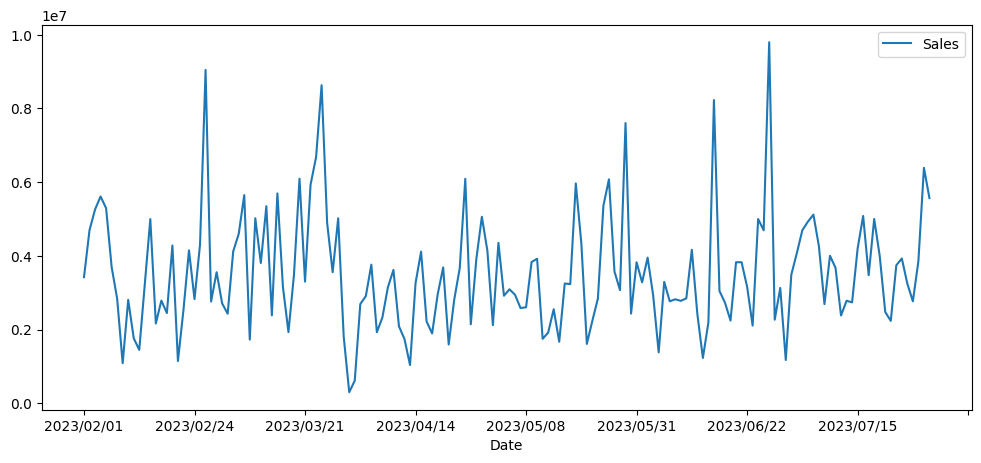

In [ ]:
sales_10TA.plot(figsize=(12,5))

In [ ]:
len(sales_10TA)

154

In [ ]:
#train test split
train = sales_10TA.iloc[:124]
test = sales_10TA.iloc[124:]

In [ ]:
#call minmaxscaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler()

In [ ]:
#scaling
scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

In [ ]:
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaler_train,scaler_train,length=n_input,batch_size = 1)

In [ ]:
X.shape

(10, 30, 1)

In [ ]:
#making model layers
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape = (n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam',loss='mse',metrics=['Accuracy'])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 100)               40800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#fit model
model.fit(generator,epochs=20)

Epoch 1/20
94/94 [==============================] - 3s 12ms/step - loss: 0.0456 - Accuracy: 0.0106
Epoch 2/20
94/94 [==============================] - 2s 19ms/step - loss: 0.0380 - Accuracy: 0.0106
Epoch 3/20
94/94 [==============================] - 2s 18ms/step - loss: 0.0374 - Accuracy: 0.0000e+00
Epoch 4/20
94/94 [==============================] - 1s 13ms/step - loss: 0.0352 - Accuracy: 0.0106
Epoch 5/20
94/94 [==============================] - 1s 12ms/step - loss: 0.0350 - Accuracy: 0.0106
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 0.0332 - Accuracy: 0.0106
Epoch 7/20
94/94 [==============================] - 1s 11ms/step - loss: 0.0328 - Accuracy: 0.0106
Epoch 8/20
94/94 [==============================] - 1s 13ms/step - loss: 0.0338 - Accuracy: 0.0106
Epoch 9/20
11/94 [==>...........................] - ETA: 1s - loss: 0.0274 - Accuracy: 0.0000e+00

KeyboardInterrupt: ignored

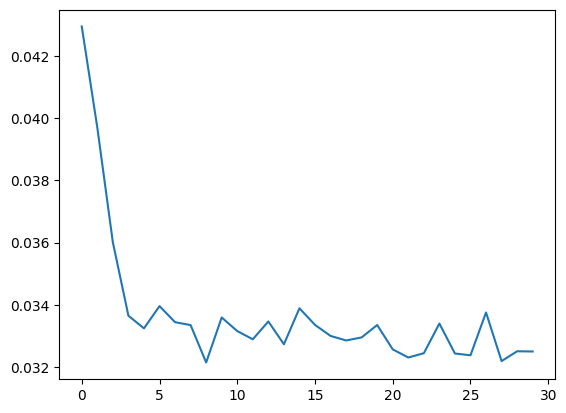

In [ ]:
#loss plot
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

PREDICTION

In [ ]:
last_train_batch = scaler_train[-30:]
last_train_batch = last_train_batch.reshape((1,n_input,n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 166ms/step


(1, 30)

In [ ]:
scaler_test[0]

array([1.08591329])

In [ ]:
test_predictions = []

first_eval_batch = scaler_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [ ]:
test_predictions

[array([0.3847089], dtype=float32),
 array([0.38212666], dtype=float32),
 array([0.3803628], dtype=float32),
 array([0.37924984], dtype=float32),
 array([0.37825412], dtype=float32),
 array([0.37618068], dtype=float32),
 array([0.37566543], dtype=float32),
 array([0.37486637], dtype=float32),
 array([0.37423155], dtype=float32),
 array([0.37352747], dtype=float32),
 array([0.37309217], dtype=float32),
 array([0.37310767], dtype=float32),
 array([0.3728125], dtype=float32),
 array([0.3726974], dtype=float32),
 array([0.37264287], dtype=float32),
 array([0.37256506], dtype=float32),
 array([0.37240878], dtype=float32),
 array([0.37182775], dtype=float32),
 array([0.37170434], dtype=float32),
 array([0.37188825], dtype=float32),
 array([0.37186703], dtype=float32),
 array([0.37021056], dtype=float32),
 array([0.37020847], dtype=float32),
 array([0.37032455], dtype=float32),
 array([0.37057343], dtype=float32),
 array([0.37048575], dtype=float32),
 array([0.37033764], dtype=float32),
 arra

In [ ]:
scaler_test

array([[1.08591329],
       [0.22509092],
       [0.32351303],
       [0.09992399],
       [0.36457101],
       [0.43158505],
       [0.50265933],
       [0.52905646],
       [0.55105512],
       [0.45238008],
       [0.27333426],
       [0.42342301],
       [0.38609494],
       [0.23809207],
       [0.28379947],
       [0.27872815],
       [0.44564604],
       [0.54683957],
       [0.36316893],
       [0.53758176],
       [0.42282632],
       [0.24891795],
       [0.22135425],
       [0.3937505 ],
       [0.41502094],
       [0.33667807],
       [0.28202362],
       [0.40686168],
       [0.69615417],
       [0.60226408]])